In [1]:
import numpy as np
import pandas as pd
import sklearn as sklearn
from matplotlib import pyplot as plt
import seaborn as sns
import math

In [6]:
X_train_raw = np.load("X_train.npy")
y_train_raw = np.load("y_train.npy")
X_test = np.load("X_test.npy")

In [7]:
random_row_indices = np.random.choice(X_train_raw.shape[0], size=int(X_train_raw.shape[0]*0.75), replace=False)
X_train = X_train_raw[random_row_indices]
y_train = y_train_raw[random_row_indices]

val_indices = np.array(list(set(range(0, X_train_raw.shape[0])).difference(set(random_row_indices))))
X_val = X_train_raw[val_indices]
y_val = y_train_raw[val_indices]


In [8]:
# --- Paste the modified quantile_plot function from above here ---
def quantile_plot(x, y, ax=None, by=None, bins=10, by_bins=3, y_fn=np.mean):
    assert len(x) == len(y)
    def qp_data(x, y):
        fac = np.searchsorted(np.quantile(x, q=[i / bins for i in range(1, bins)]), x)
        ufac = np.unique(fac)
        qx = np.array([np.mean(x[fac == f]) for f in ufac])
        qy = np.array([y_fn(y[fac == f]) for f in ufac])
        return qx, qy
    qx, qy = qp_data(x, y)
    if by is None:
        ax.plot(qx, qy, "-o")
    else:
        assert len(x) == len(by)
        ax.plot(qx, qy, "-o", label="ALL", color="lightgrey")
        by_fac = np.searchsorted(np.quantile(by, q=[i / by_bins for i in range(1, by_bins)]), by)
        by_ufac = np.unique(by_fac)
        for i, f in enumerate(np.unique(by_ufac)):
            mask = by_fac == f
            nm = f"{i}) {min(by[mask]):.2f} / {max(by[mask]):.2f}"
            qx, qy = qp_data(x[mask], y[mask])
            ax.plot(qx, qy, "-o", label=nm)
        ax.legend()
# --- End of function definition ---

In [9]:
var_count = X_train.shape[1]
train_count = X_train.shape[0]
test_count = X_test.shape[0]
var_list = ["v_"+str(i) for i in range(1, var_count+1)]

In [10]:
X_train_df = pd.DataFrame(X_train, columns=var_list)
X_test_df = pd.DataFrame(X_test, columns=var_list)
y_train_df = pd.DataFrame(y_train, columns=['y'])

In [11]:
X_val_df = pd.DataFrame(X_val, columns=var_list)
X_val_df = pd.DataFrame(X_val, columns=var_list)
y_val_df = pd.DataFrame(y_val, columns=['y'])

In [881]:
def sqr_transform(x):
    # if(abs(round(x**2, 5))<1e-4):
    #     print(x, abs(round(x**2, 5)))
    return(x**2)

def exp_transform(x):
    return(math.exp(x/2))

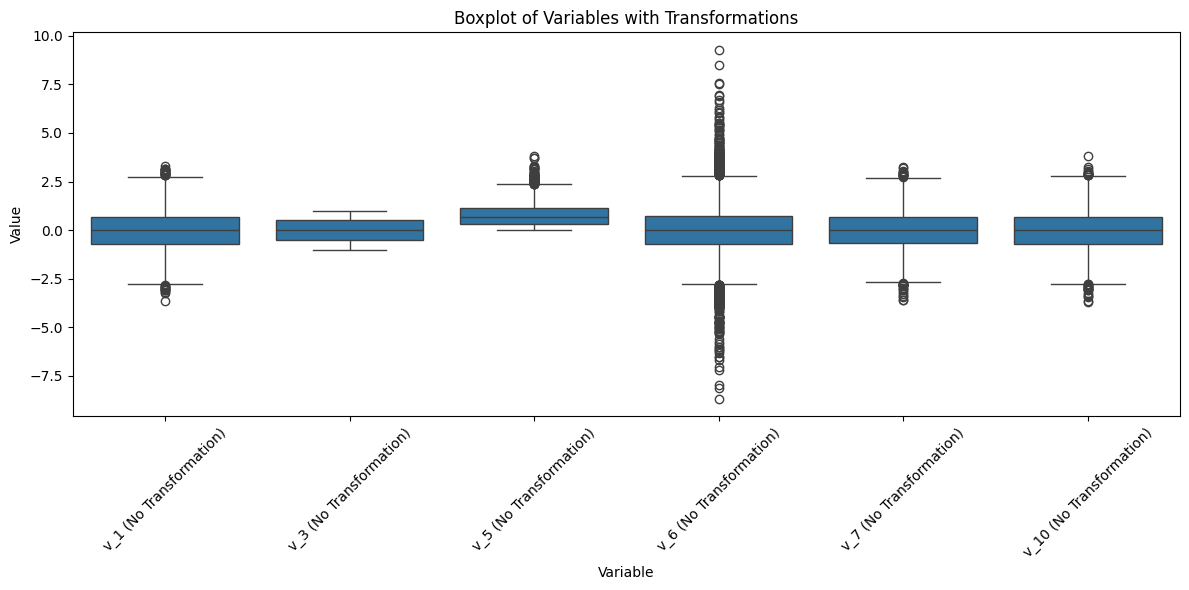

In [755]:
var_list = {'v_1': None, 'v_3': None, 'v_5': None, 
                     'v_6': None, 'v_7': None, 'v_10': None}
vars_skipped = {'v_2': None, 'v_4': None,'v_9': None, 'v_8': None}


# Collect transformed data for each variable
boxplot_data = {}

for var_name in var_list:
    transform = var_list[var_name]
    if transform is None:
        title_ = "No Transformation"
        data_to_plot = np.array(X_train_df[var_name])
    else:
        title_ = transform.__name__
        data_to_plot = np.array(X_train_df[var_name].apply(transform))

    boxplot_data[f"{var_name} ({title_})"] = data_to_plot

# Convert to long DataFrame
df_long = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in boxplot_data.items()]))
df_long = df_long.melt(var_name="Variable", value_name="Value")

# Single boxplot with all variables
plt.figure(figsize=(12,6))
sns.boxplot(x="Variable", y="Value", data=df_long)
plt.xticks(rotation=45)
plt.title("Boxplot of Variables with Transformations")
plt.tight_layout()
plt.show()


In [756]:
X_train_df_filtered = X_train_df.copy()

# selected_col_list = ['v_1', 'v_5', 'v_6', 'v_7', 'v_8', 'v_10']
selected_col_list = ['v_1', 'v_6', 'v_10']
# best config
# selected_col_list = []
for col in X_train_df.select_dtypes(include=np.number).columns:
    if(col not in selected_col_list):
        continue
    # print(col)
    upper = X_train_df[col].quantile(0.99)   # 95th percentile
    lower = X_train_df[col].quantile(0.01)   # optional: also drop low outliers
    X_train_df_filtered = X_train_df_filtered[(X_train_df_filtered[col] <= upper) & (X_train_df_filtered[col] >= lower)]

y_train_df_filtered = y_train_df.loc[X_train_df_filtered.index]

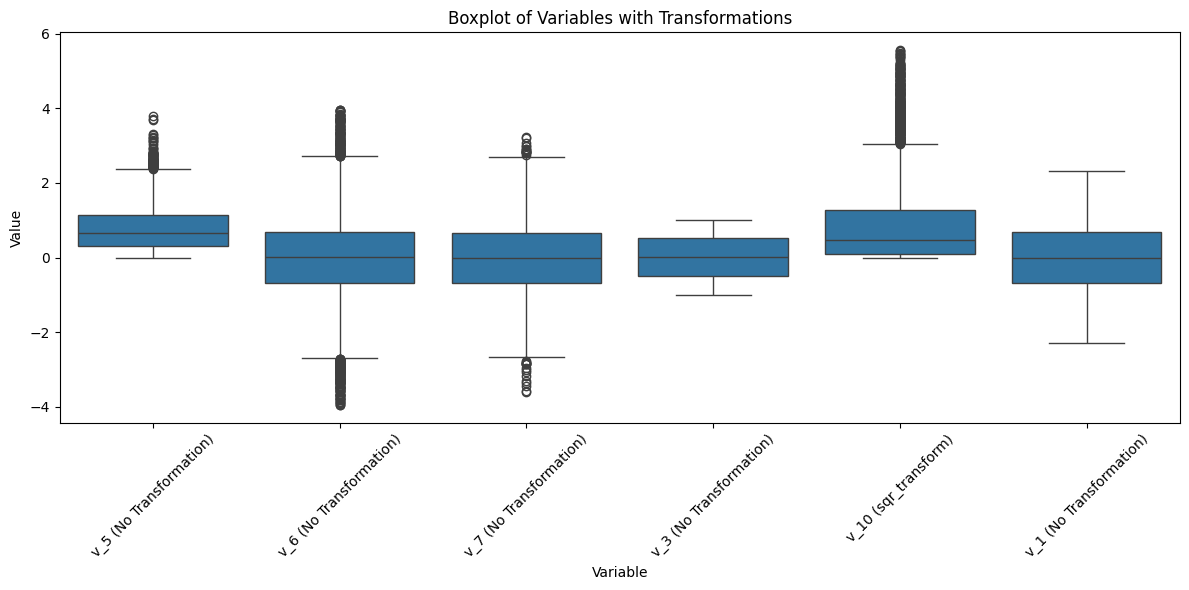

In [757]:
var_list = {'v_5': None, 'v_6': None, 'v_7': None, 'v_3': None, 
                     'v_10': sqr_transform, 'v_1': None}
vars_skipped = {'v_2': None, 'v_4': None,'v_9': None, 'v_8': None}


# Collect transformed data for each variable
boxplot_data = {}

for var_name in var_list:
    transform = var_list[var_name]
    if transform is None:
        title_ = "No Transformation"
        data_to_plot = np.array(X_train_df_filtered[var_name])
    else:
        title_ = transform.__name__
        data_to_plot = np.array(X_train_df_filtered[var_name].apply(transform))

    boxplot_data[f"{var_name} ({title_})"] = data_to_plot

# Convert to long DataFrame
df_long = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in boxplot_data.items()]))
df_long = df_long.melt(var_name="Variable", value_name="Value")

# Single boxplot with all variables
plt.figure(figsize=(12,6))
sns.boxplot(x="Variable", y="Value", data=df_long)
plt.xticks(rotation=45)
plt.title("Boxplot of Variables with Transformations")
plt.tight_layout()
plt.show()


In [758]:
len(X_train_df_filtered)

5651

In [759]:
len(y_train_df_filtered)

5651

In [760]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [1055]:
    
def run_ols(X_df, y, feature_list, transformers, model_type="regular", alpha=0.01, scaler=None):
    X_subset = X_df[feature_list].copy()
    for i in range(len(feature_list)):
        if transformers[i] is not None:
            X_subset[feature_list[i]] = X_subset[feature_list[i]].apply(transformers[i])

    if(scaler == 'standard'):
        x_scaler = StandardScaler().fit(X_subset)
        X_subset_scaled = x_scaler.transform(X_subset)
        X_subset_scaled_df = pd.DataFrame(X_subset_scaled, columns=X_subset.columns)
    if(scaler == 'min-max'):
        x_scaler = MinMaxScaler().fit(X_subset)
        X_subset_scaled = x_scaler.transform(X_subset)
        X_subset_scaled_df = pd.DataFrame(X_subset_scaled, columns=X_subset.columns)
    else:
        X_subset_scaled_df = X_subset

    if model_type == "lasso":
        model = Lasso(alpha=alpha, fit_intercept=True)
        model.fit(X_subset_scaled_df, y)
    if model_type == "ridge":
        model = Ridge(alpha=alpha, fit_intercept=True)
        model.fit(X_subset_scaled_df, y)
    if model_type == "regular":
        model = LinearRegression(fit_intercept=True)
        model.fit(X_subset_scaled_df, y)
    if model_type == "manual":
        model = fit_OLS
        model(X_subset_scaled_df, y)    
    
    # keep scaler for inference (no signature change)
    if(scaler):
        model._x_scaler = x_scaler
    return model


def pred_func(X_df, model, feature_list, transformers):
    X_subset = X_df[feature_list].copy()
    # print(X_subset.describe())
    for i in range(len(feature_list)):
        if transformers[i] != None:
            X_subset[feature_list[i]] = X_subset[feature_list[i]].apply(transformers[i])

    y_pred = model.predict(X_subset)
    # print(X_df[feature_list].head(2))
    # print(X_subset.head(2))

    return y_pred

def mse(y_pred, y_actual):

  y_pred = np.array(y_pred)
  y_actual = np.array(y_actual)

  errors = y_actual - y_pred

  squared_errors = errors ** 2

  mean_squared_error = np.mean(squared_errors)

  return mean_squared_error



In [762]:
X_train_df_filtered.describe()

,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_2_v_4
count,5651.000000,5651.000000,5651.000000,5651.000000,5651.000000,5651.000000,5651.000000,5651.000000,5651.000000,5651.000000,5651.000000
mean,-0.003483,-0.006544,0.005746,-0.018559,0.795354,0.033114,-0.009010,0.808757,-0.004733,-0.004383,0.000971
std,0.944826,0.999232,0.580212,1.161124,0.601286,1.260732,0.985620,1.172014,1.006637,0.949191,1.169932
min,-2.285327,-3.528461,-0.999782,-1.999085,0.000117,-3.943309,-3.603690,-3.221563,-3.727249,-2.357655,-5.858485
25%,-0.675659,-0.684345,-0.497654,-1.034301,0.317468,-0.670301,-0.688244,0.006383,-0.685492,-0.681626,-0.523376
50%,-0.018441,-0.031740,0.002977,-0.029897,0.668298,0.015360,-0.000278,0.756260,-0.000007,-0.003232,-0.009598
75%,0.678781,0.653358,0.519885,0.971344,1.140530,0.687147,0.663357,1.581054,0.654509,0.683483,0.512254
max,2.306875,3.971553,0.999837,1.999695,3.793571,3.954259,3.222465,5.956151,3.420870,2.253126,6.491788


In [763]:
np.array(X_train_df_filtered[['v_1', 'v_3', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10']]).shape

(5651, 8)

In [764]:
X_train_df_filtered.head()

,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_2_v_4
0,0.103759,-0.918520,0.077148,1.820894,2.469503,-1.425557,0.627572,2.665928,-1.541950,-0.751986,-1.672526
1,0.816287,1.232528,-0.161424,1.622374,0.963229,0.559897,0.754165,1.225303,-0.419018,-0.802642,1.999620
2,0.156585,-1.726887,0.105749,1.080549,1.545137,-2.552446,0.507091,1.730090,0.471617,-0.274249,-1.865987
3,-1.109653,0.263285,-0.517273,-0.243545,1.570385,-0.534219,0.628225,2.499480,0.548587,1.485222,-0.064122
4,-0.485134,-0.142494,-0.723381,1.551925,0.751051,0.201555,0.095491,2.082022,-0.523952,-0.799135,-0.221140


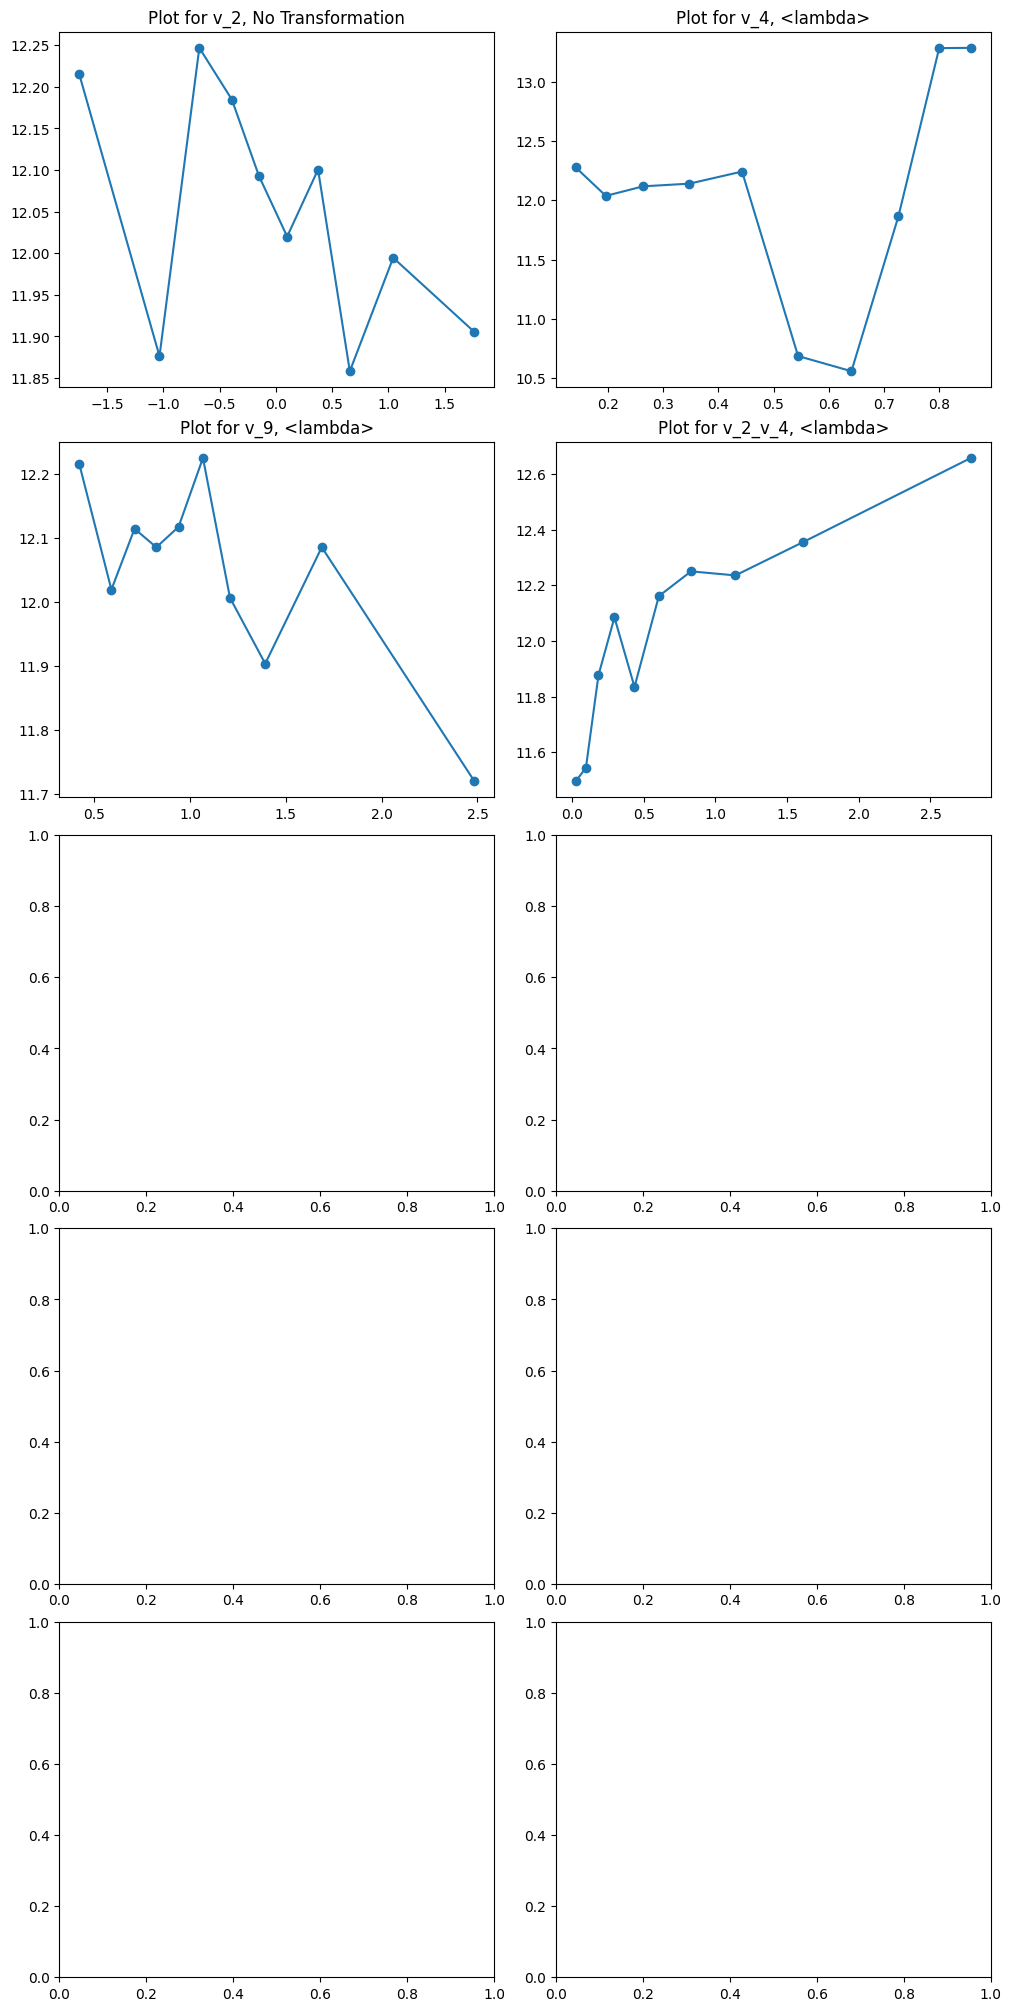

In [995]:
x_temp_df = X_train_df_filtered.copy()
y_temp_df = y_train_df_filtered.copy()

# x_temp_df = X_train_df.copy()
# y_temp_df = y_train_df.copy()


x_temp_df['v_2_v_4_v_9'] = x_temp_df['v_2'] * x_temp_df['v_4'] * x_temp_df['v_9']

# var_list = {'v_1': None, 'v_2': None, 'v_3': None, 'v_4': None, 'v_5': None, 
#                      'v_6': None, 'v_7': sqr_transform, 'v_8': sqr_transform, 'v_9': None, 'v_10': sqr_transform}

var_list = {'v_2':None, 'v_4': lambda x: 1 / (1 + np.exp(-x)), 'v_9':lambda x: (np.exp(x/2)), 'v_2_v_4': lambda x: abs(x)}

# 1. Determine the grid size
cols = 2  # You can adjust this
rows = math.ceil(var_count / cols)

# 2. Create the figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

# 3. Flatten the axes array and loop through variables and axes
for var_name, ax in zip(var_list, axes.flatten()):
    # Prepare the data for the current variable
    if(var_list[var_name] == None):
        title_ = "No Transformation"
        data_to_plot = np.array(x_temp_df[var_name])
    else:
        title_ = str(var_list[var_name]).split()[1]
        data_to_plot = np.array(x_temp_df[var_name].apply(var_list[var_name]))

    # Call your plotting function, passing the specific axis `ax` to it
    quantile_plot(x=data_to_plot, y=np.array(y_temp_df['y']).ravel(), ax=ax, bins=10)

    # Set a title for each individual subplot
    ax.set_title(f'Plot for {var_name}, {title_}')

# 4. Turn off any unused subplots
for i in range(var_count, len(axes.flatten())):
    axes.flatten()[i].axis('off')

# 5. Show the final plot
plt.show()

In [1056]:

selected_var_dict = {'v_5': None, 'v_6': None, 'v_7': lambda x: np.exp(x/3), 'v_3': lambda x: (x**3), 
                     'v_10': sqr_transform, 'v_1': None}
# 8.6198811178278 -- ridge
# 8.632882605106941 -- lasso
vars_skipped = {'v_2': None, 'v_8': None, 'v_9': None, 'v_4': None}

filtered = False
model_type = 'ridge'
scaler = None
alpha = 0.001

config = None


if(config == 1):
    selected_var_dict = {'v_5': None, 'v_6': None, 'v_7': lambda x: np.exp(x/3), 'v_3': lambda x: (x**3), 
                         'v_10': sqr_transform, 'v_1': None}
    
    vars_skipped = {'v_2': None, 'v_8': None, 'v_9': None, 'v_4': None}

    X_train_df_filtered['v_2_v_4'] = X_train_df_filtered['v_2'] * X_train_df_filtered['v_4']
    X_val_df['v_2_v_4'] = X_val_df['v_2'] * X_val_df['v_4']
    X_train_df['v_2_v_4'] = X_train_df['v_2'] * X_train_df['v_4']

    selected_var_dict['v_2_v_4'] = lambda x: abs(x)
    
    filtered = False
    model_type = 'ridge'
    scaler = None
    alpha = 5
    
    config = 3

    model = run_ols(
                    X_train_df, y_train,
                    list(selected_var_dict.keys()), list(selected_var_dict.values()),
                    model_type = 'regular', alpha=0.01, scaler=None
                   )

elif(config == 2):
    selected_var_dict = {'v_5': None, 'v_6': None, 'v_7': lambda x: np.exp(x/3), 'v_3': lambda x: (x**3), 
                     'v_10': sqr_transform, 'v_1': None}

    vars_skipped = {'v_2': None, 'v_8': None, 'v_9': None, 'v_4': None}
    
    filtered = False
    model_type = 'lasso'
    scaler = None
    alpha = 0.001

    model = run_ols(
                    X_train_df, y_train,
                    list(selected_var_dict.keys()), list(selected_var_dict.values()),
                    model_type = 'regular', alpha=0.01, scaler=None
                   )

elif(config == 3):
    selected_var_dict = {'v_5': None, 'v_6': None, 'v_7': lambda x: np.exp(x/3), 'v_3': lambda x: (x**3), 
                         'v_10': sqr_transform, 'v_1': None}
    
    vars_skipped = {'v_2': None, 'v_8': None, 'v_9': None, 'v_4': None}

    X_train_df_filtered['v_2_v_4'] = X_train_df_filtered['v_2'] * X_train_df_filtered['v_4']
    X_val_df['v_2_v_4'] = X_val_df['v_2'] * X_val_df['v_4']
    X_train_df['v_2_v_4'] = X_train_df['v_2'] * X_train_df['v_4']

    selected_var_dict['v_2_v_4'] = lambda x: abs(x)
    selected_var_dict = {'v_1': None, 'v_3': None, 'v_5': None, 
                         'v_6': None, 'v_7': None, 'v_8': None,
                         'v_9': None, 'v_10': sqr_transform}
    vars_skipped = {'v_2': None, 'v_4': None}

    filtered = False
    model_type = 'regular'
    scaler = None
    alpha = 0.001
    
    model = run_ols(
                    X_train_df, y_train,
                    list(selected_var_dict.keys()), list(selected_var_dict.values()),
                    model_type = 'regular', alpha=0.01, scaler=None
                   )

else:
    
    
    if(filtered == True):        
        model = run_ols(
                        X_train_df_filtered, np.array(y_train_df_filtered['y']),
                        list(selected_var_dict.keys()), list(selected_var_dict.values()),
                        model_type = model_type, alpha=alpha, scaler=scaler
                       )
    else:
        model = run_ols(
                        X_train_df, np.array(y_train_df['y']),
                        list(selected_var_dict.keys()), list(selected_var_dict.values()),
                        model_type = model_type, alpha=alpha, scaler=scaler
                       )


In [1057]:
try:
    X_subset = model._x_scaler.transform(X_train_df[selected_var_dict.keys()])
    X_subset_df = pd.DataFrame(X_subset, columns=selected_var_dict.keys())
    
    y_pred_train = pred_func(X_subset_df, model, list(selected_var_dict.keys()), list(selected_var_dict.values()))
except:
    y_pred_train = pred_func(X_train_df, model, list(selected_var_dict.keys()), list(selected_var_dict.values()))
    
error_naive = mse(np.mean(y_train), y_train)
error = mse(y_pred_train, y_train)


# Print the result
print(f"Training Mean Squared Error (naive): {error_naive}")
print(f"Training Mean Squared Error (model): {error}")

Training Mean Squared Error (naive): 13.110301314349154
Training Mean Squared Error (model): 8.704744494764569


/Users/abhishek_shukla/sklearn-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/abhishek_shukla/sklearn-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/abhishek_shukla/sklearn-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [1058]:
print(1-np.var(y_pred_train)/np.var(y_train)) # r2
print(np.mean(y_pred_train), np.mean(y_train))


0.6639625888294748
12.09908179015958 12.09908179015958


In [1059]:
model.coef_

array([-1.62873138,  0.65451102, -2.7562907 ,  1.98607662,  0.55897688,
       -0.61926652])

In [1060]:
model.intercept_

np.float64(15.699138173878694)

In [1061]:
model.feature_names_in_

array(['v_5', 'v_6', 'v_7', 'v_3', 'v_10', 'v_1'], dtype=object)

In [1052]:
try:
    X_subset = model._x_scaler.transform(X_val_df[selected_var_dict.keys()])
    X_subset_df = pd.DataFrame(X_subset, columns=selected_var_dict.keys())
    
    y_pred_val = pred_func(X_subset_df, model, list(selected_var_dict.keys()), list(selected_var_dict.values()))
except:
    y_pred_val = pred_func(X_val_df, model, list(selected_var_dict.keys()), list(selected_var_dict.values()))
    
error_naive = mse(np.mean(y_val), y_val)
error = mse(y_pred_val, y_val)


# Print the result
print(f"Validation Mean Squared Error (naive): {error_naive}")
print(f"Validation Mean Squared Error (model): {error}")

Validation Mean Squared Error (naive): 13.596951949419285
Validation Mean Squared Error (model): 8.6198811178278


/Users/abhishek_shukla/sklearn-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/abhishek_shukla/sklearn-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/abhishek_shukla/sklearn-env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


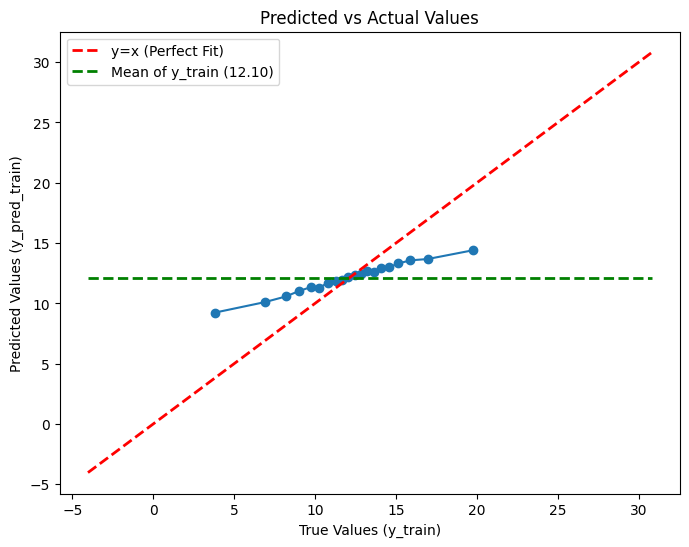

In [1016]:
error = y_pred_train - y_train


# Set up the plot using the object-oriented approach
fig, ax = plt.subplots(figsize=(8, 6))

# plt.scatter(
#     x=y_train.reshape(-1), 
#     y=y_pred_train.reshape(-1),
#     alpha=0.6
# )

# Call your custom plotting function
quantile_plot(x=y_train.reshape(-1), y=y_pred_train.reshape(-1), ax=ax, bins=20)

# --- Add Reference Lines ---

# 1. Define the plot limits and the mean value
lims = [
    np.min([y_train, y_pred_train]),
    np.max([y_train, y_pred_train]),
]

y_mean = [np.mean(y_train), np.mean(y_train)]


# 2. Plot the y=x line (perfect prediction)
# It's good practice to use ax.plot() when you have an ax object
ax.plot(lims, lims, 'r--', linewidth=2, label='y=x (Perfect Fit)')

# 3. Plot the horizontal line for the mean of y_train
# Use the plot limits for x and the constant mean for y
ax.plot(lims, y_mean, 'g--', linewidth=2, label=f'Mean of y_train ({y_mean[0]:.2f})')


# --- Final Touches ---
# Use the 'set_' methods when working with an ax object
ax.set_xlabel("True Values (y_train)")
ax.set_ylabel("Predicted Values (y_pred_train)")
ax.set_title("Predicted vs Actual Values")
ax.legend() # Display the labels for the lines
plt.show()

In [1017]:
print(1-np.var(y_pred_train)/np.var(y_train)) # r2
print(np.mean(y_pred_train), np.mean(y_train))


0.6565661037761634
12.099081790159577 12.09908179015958


In [1018]:
print(1-np.var(y_pred_val)/np.var(y_val)) # r2
print(np.mean(y_pred_val), np.mean(y_val))


0.6620812367606379
12.084113120709212 12.054441467948248


In [1019]:
print(1-np.var(np.append(y_pred_val, y_pred_train))/np.var(np.append(y_val, y_train)))  # r2
print(np.mean(np.append(y_pred_val, y_pred_train)), np.mean(np.append(y_val, y_train)))


0.6579894017631391
12.095339622796986 12.087921709606748


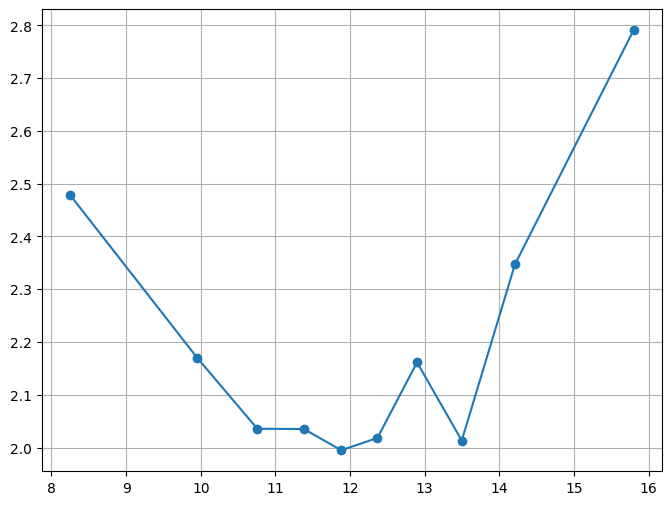

In [1020]:
error = abs(y_pred_train - y_train)


# Set up the plot using the object-oriented approach
fig, ax = plt.subplots(figsize=(8, 6))

# plt.scatter(
#     x=y_pred_train.reshape(-1), 
#     y=error.reshape(-1),
#     alpha=0.6
# )

quantile_plot(x=y_pred_train.reshape(-1), y=error.reshape(-1), ax=ax, bins=10)

plt.grid(True)

In [1021]:
mse_ = [12.1668, 11.2683, 10.5399, 10.0399, 9.4438, 9.0534, 9.0118]
r2_ = [0.9279, 0.8578, 0.8113, 0.7708, 0.7073, 0.6814, 0.6788]

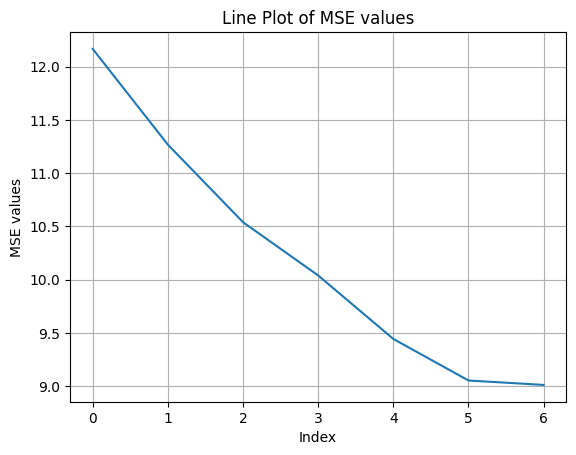

In [1022]:
# Create the line plot
plt.plot(mse_)

# Add labels and a title for clarity
plt.xlabel("Index")
plt.ylabel("MSE values")
plt.title("Line Plot of MSE values")

# Add a grid for better readability
plt.grid(True)

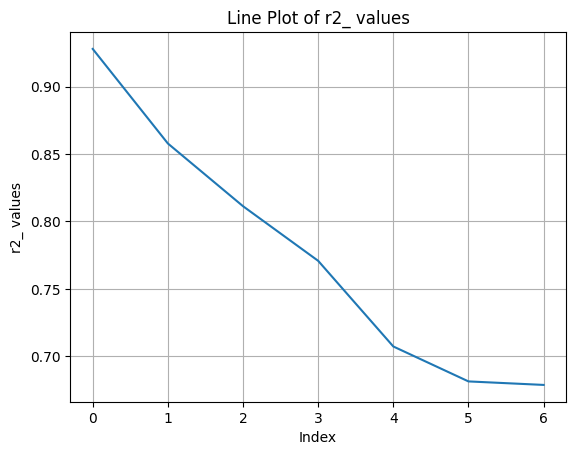

In [663]:
# Create the line plot
plt.plot(r2_)

# Add labels and a title for clarity
plt.xlabel("Index")
plt.ylabel("r2_ values")
plt.title("Line Plot of r2_ values")

# Add a grid for better readability
plt.grid(True)

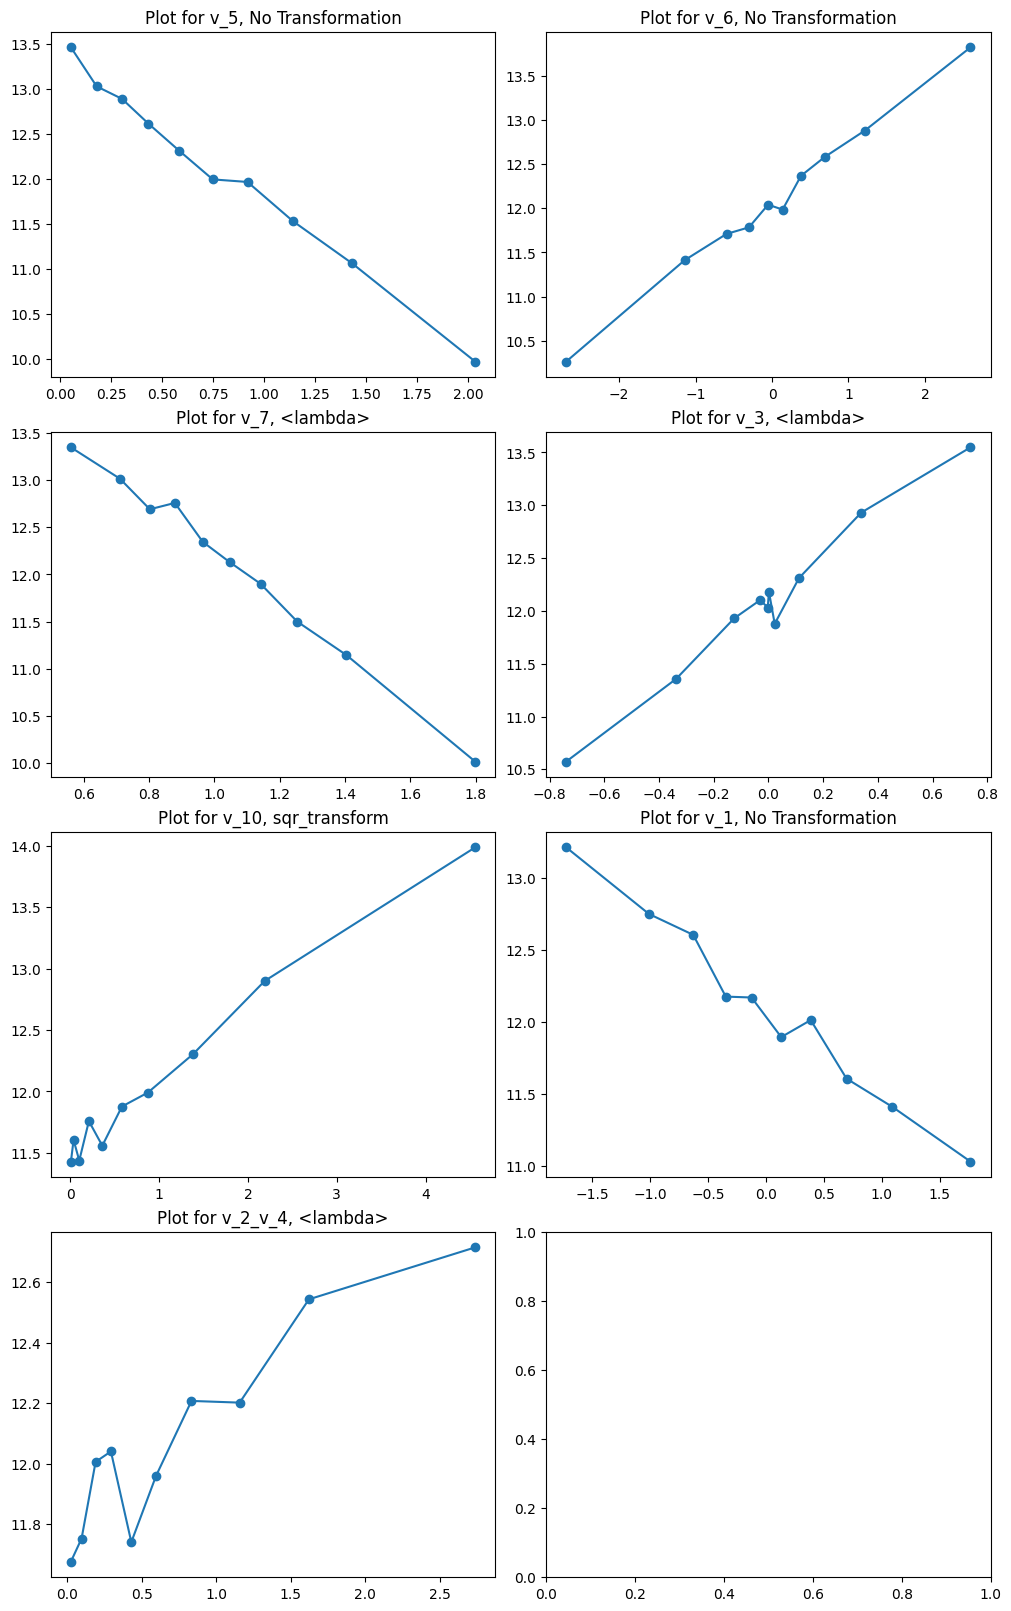

In [1023]:
x_temp_df = X_val_df.copy()
y_temp_df = pd.DataFrame(y_pred_val, columns=['y'])


# var_list = {'v_5': None, 'v_6': None, 'v_7': lambda x: np.exp(x/3), 'v_3': lambda x: x**3, 
#                      'v_10': lambda x: x**2, 'v_1': None}

var_list = selected_var_dict

# 1. Determine the grid size
cols = 2  # You can adjust this
rows = math.ceil(len(var_list) / cols)

# 2. Create the figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

# 3. Flatten the axes array and loop through variables and axes
for var_name, ax in zip(var_list, axes.flatten()):
    # Prepare the data for the current variable
    if(var_list[var_name] == None):
        title_ = "No Transformation"
        data_to_plot = np.array(x_temp_df[var_name])
    else:
        title_ = str(var_list[var_name]).split()[1]
        data_to_plot = np.array(x_temp_df[var_name].apply(var_list[var_name]))

    # Call your plotting function, passing the specific axis `ax` to it
    quantile_plot(x=data_to_plot, y=np.array(y_temp_df['y']).ravel(), ax=ax, bins=10)

    # Set a title for each individual subplot
    ax.set_title(f'Plot for {var_name}, {title_}')

# 4. Turn off any unused subplots
for i in range(var_count, len(axes.flatten())):
    axes.flatten()[i].axis('off')

# 5. Show the final plot
plt.show()

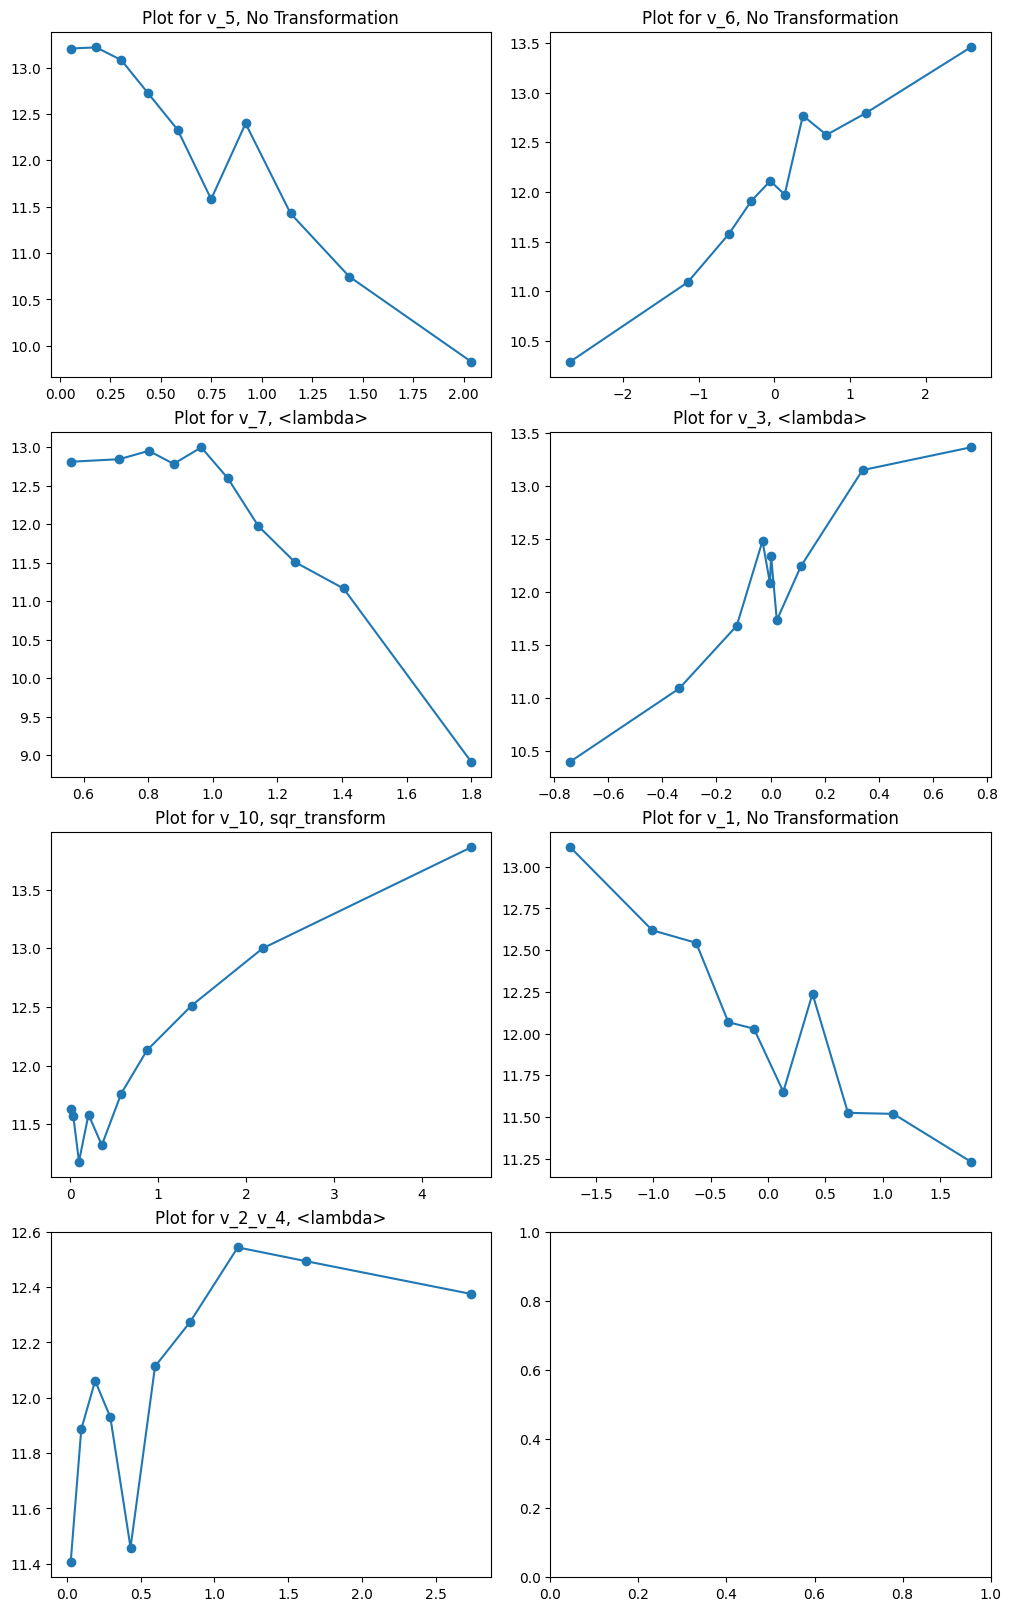

In [1024]:
x_temp_df = X_val_df.copy()
y_temp_df = pd.DataFrame(y_val, columns=['y'])


# var_list = {'v_5': None, 'v_6': None, 'v_7': lambda x: np.exp(x/3), 'v_3': lambda x: x**3, 
#                      'v_10': sqr_transform, 'v_1': None}

var_list = selected_var_dict

# 1. Determine the grid size
cols = 2  # You can adjust this
rows = math.ceil(len(var_list) / cols)

# 2. Create the figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

# 3. Flatten the axes array and loop through variables and axes
for var_name, ax in zip(var_list, axes.flatten()):
    # Prepare the data for the current variable
    if(var_list[var_name] == None):
        title_ = "No Transformation"
        data_to_plot = np.array(x_temp_df[var_name])
    else:
        title_ = str(var_list[var_name]).split()[1]
        data_to_plot = np.array(x_temp_df[var_name].apply(var_list[var_name]))

    # Call your plotting function, passing the specific axis `ax` to it
    quantile_plot(x=data_to_plot, y=np.array(y_temp_df['y']).ravel(), ax=ax, bins=10)

    # Set a title for each individual subplot
    ax.set_title(f'Plot for {var_name}, {title_}')

# 4. Turn off any unused subplots
for i in range(var_count, len(axes.flatten())):
    axes.flatten()[i].axis('off')

# 5. Show the final plot
plt.show()